In [1]:
import torch
from torchvision import datasets, transforms

# Load the FashionMnist dataset
The FashionMnist dataset is a direct replacement for the Mnist dataset. Containing images of clothes instead of numbers.
The dataset is available here: https://github.com/zalandoresearch/fashion-mnist but can be directly downloaded through pytorch.


In [2]:
class FashionMnist:
    def __init__(self, batch_size, transform = transforms.Compose([
            transforms.ToTensor(), #convert image to PyTorch tensor
            transforms.Normalize((0.1307,),(0.3081,)) # normalization 
        ]) ):
        dataset_transform = transform
        self.training_data = datasets.FashionMNIST('./data/fashionmnist', train = True, transform = dataset_transform, 
                                          download = True )
        self.test_data = datasets.FashionMNIST('./data/fashionmnist', train = False,  transform = dataset_transform, 
                                      download = True )
        
        #batching and shuffeling data
        self.train_loader  = torch.utils.data.DataLoader(self.training_data, batch_size=batch_size, shuffle=True)
        self.test_loader  = torch.utils.data.DataLoader(self.test_data, batch_size=batch_size, shuffle=True)
        

Here I just plot some images from the dataset, to see what it looks like.

In [3]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

batch_size = 100
mnist = FashionMnist(batch_size, transform = None)

labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};

fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;

for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(mnist.training_data));
    img = mnist.training_data[img_xy][0]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[mnist.training_data[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

  0%|          | 0/26421880 [00:00<?, ?it/s]

26427392it [00:02, 10464176.05it/s]                              


Extracting ./data/fashionmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/fashionmnist/FashionMNIST/raw


32768it [00:00, 269715.02it/s]                           
0it [00:00, ?it/s]

Extracting ./data/fashionmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/fashionmnist/FashionMNIST/raw


4423680it [00:00, 8230176.80it/s]                            
8192it [00:00, 111713.19it/s]


Extracting ./data/fashionmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/fashionmnist/FashionMNIST/raw
Extracting ./data/fashionmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/fashionmnist/FashionMNIST/raw
Processing...
Done!


<Figure size 800x800 with 20 Axes>

Those are the class labels:
<div>
<img src="figures\image.png" width = "180"/>
</div>

# Architecture


<div>
<img src="figures\architecture_encoder.gif" width = "880"/>
</div>
This is the architecture for the MNIST dataset proposed by Sabour et al. (2017). There is a convolutional layer first, followed by two capsule layers.

## Convolutional Layer
**Input:** 28x28x1 (image size and grey scale channel)

**Output:** 20x20x256

The first layer is a convolutional layer and extracts basic features. The images in the FashionMnist dataset have an input size of 28x28 pixels. We convolve with 256 kernels of size 9x9 over the input image. This results in 256 output images of size 20x20 (the output size of a convolutional network is $(input size - kernel size)+1$.
We then apply a Rectified Linear Unit.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# parameters taken from paper
class ConvLayer(nn.Module):
    def __init__(self, in_channels=1, out_channels=256, kernel_size=9):
        super(ConvLayer, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=kernel_size,
                               stride=1
                             )

    def forward(self, x):
        return F.relu(self.conv(x))

## First Capsule Layer

**Input:** 20x20x256

**Output:** 1152x8

So now, instead of having a pooling layer, we get to our first capsule layer. Well, this isn't really a proper capsule layer, but actually another convolutional layer. The only new thing we do here, is to *reshape* and *squash*.

This time we convolve with kernels of size 9x9x256, as we have a stack of 256 outputs from before. The stride this time is 2. We then get 256 output images of size 6x6 (this time $\frac{(inputsize - kernelsize) + 1}{2}$, as we have stride 2).
We then can then *reshape* this stack by splitting it into 32 decks, each containing 8 output images of size 6x6. 
<div>
<img src="figures\capsule_layer.gif" width = "500"/>
</div>
We get in each deck 36 capsules, and 32 decks in total. This amounts to $36 * 32 = 1152$  capsules.
The last step is to squash those capsules.
Remember the squash function:

$$v_j = \frac{\|s_j\|^2 }{1+\|s_j\|^2} \frac{s_j}{\|s_j\|}$$

In [5]:
class PrimaryCaps(nn.Module):
    # perform depthwise convolution
    def __init__(self, in_channels = 256 , out_channels = 256 , kernel_size = 9, groups = 256, stride = 2):
        super(PrimaryCaps,self).__init__()
        self.primary_caps = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                                  kernel_size = kernel_size, stride = stride)  
    
    def forward(self, x):
        u = self.primary_caps(x)
        u = u.view(x.size(0), 32 * 6 * 6, -1) 
        return self.squash(u)

    def squash(self, tensor):
        squared_norm = (tensor ** 2).sum(-1, keepdim=True)
        scaled = squared_norm/(1+squared_norm)
        return scaled*tensor/torch.sqrt(squared_norm)

## Second Caps Layer

**Input:** 1152x8

**Output:** 10x16

Now we have a "proper" capsule layer.
We have a vector input (of size 1x8). Those inputs get multiplied with affine transformation matrices W. On the transformed vectors we then use routing by agreement. 
For each input vector we determine the coupling coefficient to the next layer capsule. As we have 10 classes, we have 10 capsules to route to. Each capsules has a size of 16, which is the choice they made in the paper. The length of each of those 10 16-dimensional vectors, gives us the confidence for the corresponding class.

In [6]:
class SecondCaps(nn.Module):
    def __init__(self, num_capsules=10, previous_capsules=32 * 6 * 6, in_channels=8, out_channels=16):
        super(SecondCaps, self).__init__()

        self.in_channels = in_channels
        self.previous_capsules = previous_capsules
        self.num_capsules = num_capsules

        self.W = nn.Parameter(torch.randn(1, previous_capsules, num_capsules, out_channels, in_channels))

    def forward(self, x):
        batch_size = x.size(0)
        x = torch.stack([x] * self.num_capsules, dim=2).unsqueeze(4)

        W = torch.cat([self.W] * batch_size, dim=0) #
        u_hat = torch.matmul(W, x) #W*x = u_hat

        num_iterations = 3  # taken from paper
        v_j = self.routing_by_agreement(u_hat, num_iterations)

        return v_j.squeeze(1)
    
    def routing_by_agreement(self, u_hat, num_iterations):
        b_ij = torch.zeros(1, self.previous_capsules, self.num_capsules, 1) #initialize b_ij = 0
        for iteration in range(num_iterations): 
            c_ij = F.softmax(b_ij, dim = 1) # scale each capsules weights so they sum to 1
            c_ij = torch.cat([c_ij] * batch_size, dim=0).unsqueeze(4)
            # transformed vectors get multiplied element-wise with the coupling coefficients
            # for each high level capsule, the sum over all lower level capsules inputs is calculated
            s_j = (c_ij * u_hat).sum(dim=1, keepdim=True) 
            v_j = self.squash(s_j) # normalize with squash function
            # don't need to calculate new b_ij in last iteration   
            if iteration < num_iterations - 1:
                a_ij = torch.matmul(u_hat.transpose(3, 4), torch.cat([v_j] * self.previous_capsules, dim=1))
                b_ij = b_ij + a_ij.mean(dim=0, keepdim=True).squeeze(4)
        return v_j
    
    def squash(self, tensor):
        squared_norm = (tensor ** 2).sum(-1, keepdim=True)
        scaled = squared_norm/(1+squared_norm)
        return scaled*tensor/torch.sqrt(squared_norm)

## Reconstruction

The next layer reconstructs the image from the instantiation parameters given by the capsule output.
<div>
<img src="figures\Decoder.png" width = "700"/>
</div>

It is a simple fully connected network. It is later used for regularization.  

In [7]:
class Decoder(nn.Module):
    def __init__(self, num_capsule_param = 16, num_capsules=10, num_hidden = 512):
        super(Decoder, self).__init__()
        
        self.reconstruction_layers = nn.Sequential(
            nn.Linear(num_capsule_param* num_capsules, 512),
            nn.ReLU(inplace=True),
            nn.Linear(num_hidden, num_hidden*2),
            nn.ReLU(inplace=True),
            nn.Linear(num_hidden*2, 28 * 28),
            nn.Sigmoid()
        )
        
    def forward(self, x, data):
        # calculate length for each capsule
        caps_classes = torch.sqrt((x ** 2).sum(2))
        caps_classes = F.softmax(caps_classes, dim = 1)
        # find capsule with maximum vector length, reflecting highest probability
        max_indices = caps_classes.argmax(dim=1)
        mask_matrix =torch.eye(10)
        mask_matrix = mask_matrix.index_select(dim=0, index=max_indices.squeeze(1).data)
        y = (x * mask_matrix[:, :, None, None]).view(x.size(0), -1)
        reconstructions = self.reconstruction_layers(y)
        
        reconstructions = reconstructions.view(-1, 1, 28, 28)

        return reconstructions, mask_matrix


## Network
Now we have all our layers and we can put them together.




In [8]:
class CapsNet(nn.Module):
    def __init__(self):
        super(CapsNet, self).__init__()
        self.conv_layer = ConvLayer()
        self.primary_capsules = PrimaryCaps()
        self.second_capsules = SecondCaps()
        self.decoder = Decoder()
        
     
    def forward(self, data):
        output = self.second_capsules(self.primary_capsules(self.conv_layer(data)))
        reconstructions, masked = self.decoder(output, data)
        return output, reconstructions, masked

## Loss function

Our loss function is the sum of of the margin loss and the reconstruction loss.

The paper uses a special margin loss to make it possible to detect two or more different digits in each image:

$$L_k = T_k \max(0, m^{+} - \|\mathbf{v}_k\|)^2 + \lambda (1 - T_k) \max(0, \|\mathbf{v}_k\| - m^{-})^2$$

$T_k$ is equal to 1 if the digit of class $k$ is present, or 0 otherwise.
In the paper, $m^{+} = 0.9$, $m^{-} = 0.1$ and $\lambda = 0.5$.

The reconstruction loss is the euclidean distance between the reconstructed and the original image.


In [9]:
class CapsuleLoss(nn.Module):
    def __init__(self):
        super(CapsuleLoss,self).__init__()
        self.mse_loss = nn.MSELoss()
            
    # our loss is margin_loss + reconstruction_loss
    # the reconstruction loss is multiplied with 0.0005 to ensure that the margin loss dominates the total loss
    def forward(self, data, x, target, reconstructions):
        return self.margin_loss(x, target) + (0.0005*self.reconstruction_loss(data, reconstructions))
    
    # special margin_loss definied in the paper
    def margin_loss(self, x, labels,lamda = 0.5, size_average=True):
        batch_size = x.size(0)

        v_c_norm = torch.sqrt((x**2).sum(dim=2, keepdim=True))

        left = ((F.relu(0.9 - v_c_norm))**2).view(batch_size, -1)
        right = ((F.relu(v_c_norm - 0.1))**2).view(batch_size, -1)

        loss = labels * left + lamda * (1.0 - labels) * right
        loss = loss.sum(dim=1).mean()

        return loss
    
    # squared difference between reconstructed and original image
    def reconstruction_loss(self, data, reconstructions):
        loss = self.mse_loss(reconstructions.view(reconstructions.size(0), -1), data.view(reconstructions.size(0), -1))
        return loss 

## Training and Testing

In [10]:
from torch.autograd import Variable
from torch.optim import Adam

capsule_net = CapsNet()
capsule_loss = CapsuleLoss()
# optimizer used in the paper
optimizer = Adam(capsule_net.parameters())

In [11]:
n_epochs = 1 # the more epochs, the longer the training, but better results. Try what works on your computer.
batch_size = 100
mnist = FashionMnist(batch_size)

for epoch in range(n_epochs):
    capsule_net.train()
    train_loss = 0
    for batch_id, (data, target) in enumerate(mnist.train_loader):

        target = torch.eye(10).index_select(dim=0, index=target)
        data, target = data, target

        optimizer.zero_grad()
        output, reconstructions, masked = capsule_net(data)
        loss = capsule_loss(data, output, target, reconstructions)
        loss.backward()
        optimizer.step()

        train_loss += loss.data
        
        if batch_id % 100 == 0:
            accuracy = sum(np.argmax(masked.data.cpu().numpy(), 1) == 
                           np.argmax(target.data.cpu().numpy(), 1)) / float(batch_size)
            print ("Epoch: {} \t Train accuracy: {}".format(epoch, accuracy))
       
    print ("Training Loss: {}".format(train_loss / len(mnist.train_loader)))
        
    capsule_net.eval()
    test_loss = 0
    for batch_id, (data, target) in enumerate(mnist.test_loader):

        target = torch.eye(10).index_select(dim=0, index=target)
        data, target = data, target

        output, reconstructions, masked = capsule_net(data)
        loss = capsule_loss(data, output, target, reconstructions)

        test_loss += loss.data
        
        if batch_id % 100 == 0:
            accuracy = sum(np.argmax(masked.data.cpu().numpy(), 1) == 
                                   np.argmax(target.data.cpu().numpy(), 1)) / float(batch_size)
            print ("Epoch: {} \t Test accuracy: {}".format(epoch,accuracy) )
    
    print("Test Loss: {}".format(test_loss / len(mnist.test_loader)))



Epoch: 0 	 Train accuracy: 0.08
Epoch: 0 	 Train accuracy: 0.82
Epoch: 0 	 Train accuracy: 0.83
Epoch: 0 	 Train accuracy: 0.82
Epoch: 0 	 Train accuracy: 0.83
Epoch: 0 	 Train accuracy: 0.89
Training Loss: 0.17198263108730316
Epoch: 0 	 Test accuracy: 0.87
Test Loss: 0.1036573126912117


## Reconstructed images

To see how good the network works, we can plot the reconstructed images and compare them to the original images.

In [12]:
def plot_images(images):
    fig = plt.figure()
    for j in range(1, 7):
        ax = fig.add_subplot(1, 6, j)
        ax.matshow(images[j-1], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

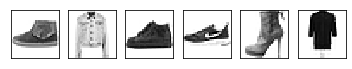

In [13]:
plot_images(data[:6,0].data.cpu().numpy())

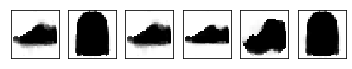

In [14]:
plot_images(reconstructions[:6,0].data.cpu().numpy())

https://github.com/gram-ai/capsule-networks

https://github.com/higgsfield/Capsule-Network-Tutorial/blob/master/Capsule%20Network.ipynb
